**PART 4: Convexity and Constrained Optimization**

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

Generating random (gaussian) arrays

In [2]:
d, n = 8, 768
A = np.random.normal(0, 1, (d, n))
b =np.random.normal(0,1,d)
x0 = np.random.normal(0, 1, n)

In [3]:
data=pd.read_csv('energy.csv')
data_copy=data.copy()
AA = data_copy[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area','Overall_Height', 'Orientation', 'Glazing_Area','Glazing_Area_Distribution']]
yy=data_copy[['Heating_Load']]

m=AA.mean(axis=0)
s=AA.std(axis=0)
my=yy.mean()

AA=(AA-m)/s
yy=yy-my

n=AA.shape[0]
d=AA.shape[1]

A_mat=AA.to_numpy()
y_mat=yy.to_numpy().reshape(n)



Usefuls functions:

In [4]:
#Conditional Gradient 
#l2 ball
def CG_l2(A,b, max_iter=500, tol=1e-8):
    x_t = sparse.dok_matrix((n, 1))
    trace = [] 

    Atb = A.T.dot(b)
    for it in range(max_iter):
        Ax = x_t.T.dot(A.T).ravel()
        grad = (A.T.dot(Ax) - Atb)
        mag_oracle = sparse.dok_matrix((n, 1))
        for j in range(n):
          mag_oracle[j] = np.sign(-grad[j])*np.abs(grad[j])/np.linalg.norm(grad)
        g_t = x_t.T.dot(grad).ravel() - mag_oracle.T.dot(grad).ravel() 
        trace.append(g_t)
        if g_t <= tol:
            break
        q_t = mag_oracle.T.dot(A.T).ravel() - Ax
        step_size = min(q_t.dot(b - Ax) / q_t.dot(q_t), 1.)
        x_t = (1. - step_size) * x_t + step_size * mag_oracle
    return x_t, np.array(trace)

#l1 ball

def CG_l1(A,b, max_iter=500, tol=0):
    x_t = sparse.dok_matrix((n, 1))
    trace = [] 

    
    Atb = A.T.dot(b)
    for it in range(max_iter):

        Ax = x_t.T.dot(A.T).ravel()
        grad = (A.T.dot(Ax) - Atb)

        idx_oracle = np.argmax(np.abs(grad))
        mag_oracle = 1 * np.sign(-grad[idx_oracle])
        g_t = x_t.T.dot(grad).ravel() - grad[idx_oracle] * mag_oracle
        trace.append(g_t)
        if g_t <= tol:
            break
        q_t = A[:, idx_oracle] * mag_oracle - Ax
        step_size = min(q_t.dot(b - Ax) / q_t.dot(q_t), 1.)
        x_t = (1. - step_size) * x_t
        x_t[idx_oracle] = x_t[idx_oracle] + step_size * mag_oracle
    return x_t, np.array(trace)

In [5]:
#Projected Gradient
#l2 ball
def proj_l2(x):
    return x/max(1,np.linalg.norm(x))

def least_squares(A, b, x):
    return (0.5/n) * np.linalg.norm(A.dot(x)-b)**2

def least_squares_gradient(A, b, x):
    return A.T.dot(A.dot(x)-b)/n

def lasso(A, b, x, alpha=0.1):
    return least_squares(A, b, x) + alpha * np.linalg.norm(x, 1)

def ell1_subgradient(x):
    g = np.ones(x.shape)
    g[x < 0.] = -1.0
    return g

def lasso_subgradient(A, b, x, alpha=0.1):
    return least_squares_gradient(A, b, x) + alpha*ell1_subgradient(x)

def gradient_descent(init, steps, grad, proj=lambda x: x):
    xs = [init]
    for step in steps:
        xs.append(proj(xs[-1] - step * grad(xs[-1])))
    return xs

#l1 ball projection

def proj_l1(x):
    return x/max(1,np.linalg.norm(x,1))




In [6]:
#plotting
def error_plot(ys, yscale='log', title=''):
    #plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys)), ys)

***Question 1***

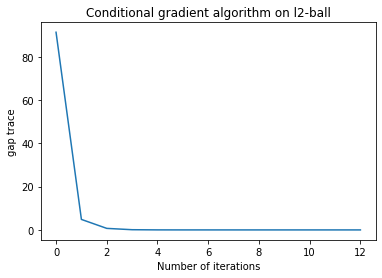

In [8]:
#Conditional Gradient on l2-ball
sol, trace = CG_l2(A,b)
plt.plot(trace)
#plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('gap trace')
plt.title('Conditional gradient algorithm on l2-ball')
plt.show()

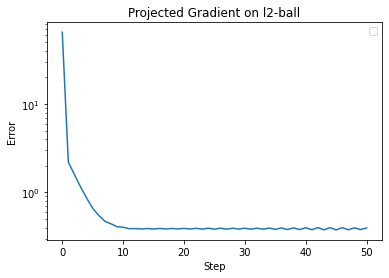

In [ ]:
#Projected Gradient on l2-ball
xs = gradient_descent(x0, [0.1]*50, lambda x: lasso_subgradient(A, b, x),proj_l2)
error_plot([lasso(A, b, x) for x in xs], title='Projected Gradient on l2-ball')
_ = plt.legend();

***Question 2***

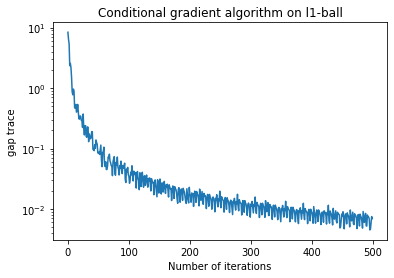

In [ ]:
#Conditional Gradient on l1-ball
sol, trace = CG_l1(A,b)
plt.plot(trace)
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('gap trace')
plt.title('Conditional gradient algorithm on l1-ball')
plt.show()

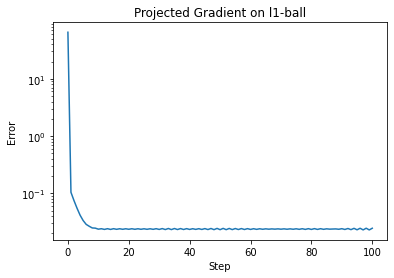

In [ ]:
#Projected Gradient on l1-ball
xs = gradient_descent(x0, [0.005]*100, lambda x: lasso_subgradient(A, b, x),proj_l1)
error_plot([lasso(A, b, x) for x in xs], title='Projected Gradient on l1-ball')